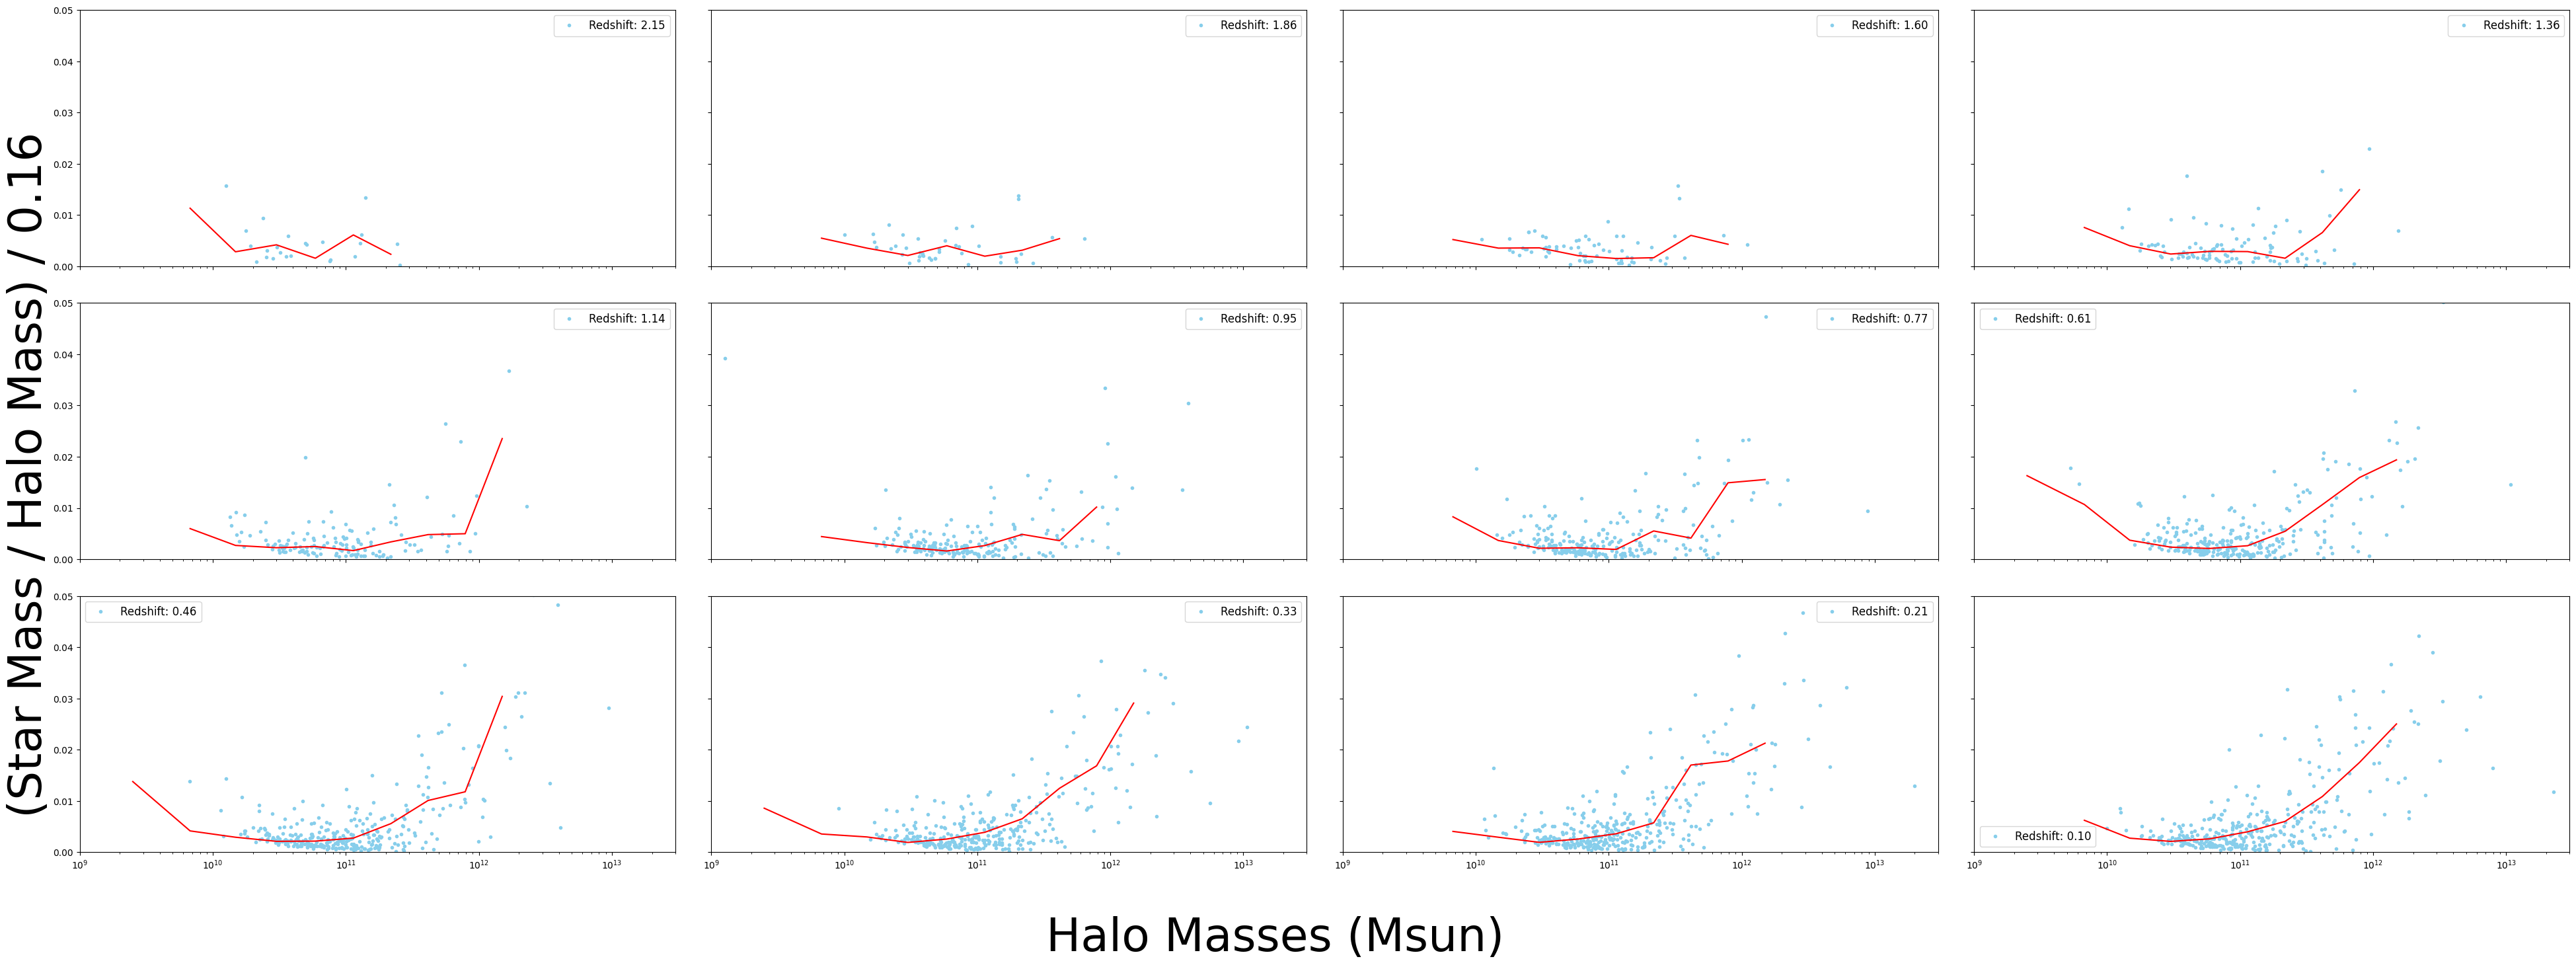

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15
from astropy import units as u
from scipy import stats
from scipy.stats import binned_statistic

#import os
#os.listdir("./SimbaTNG-EOStest_CAMELS") 
#can use conditionals

#try using scipy.stats.binned_statistic,


def bin_data(array_non_0_mass_list, ratio, num_bins): 
    if len(array_non_0_mass_list) == 0:
        return np.array([]), np.array([])

    min_value = array_non_0_mass_list.min() * 0.9999
    max_value = array_non_0_mass_list.max() * 1.0001

    bin_range = (5e9, 3e12)

    bins = np.geomspace(*bin_range, num_bins + 1)

    bin_means, bin_edges, binnumber = stats.binned_statistic(
        array_non_0_mass_list,ratio, statistic="median", bins=bins
    )
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[1:] - bin_width) / 2

    # binned_x = binned_stats.bin_edges[:-1]
    # bin_averages = binned_stats.statistic

    valid_indices = bin_means!=0
    binned_x = bin_centers[valid_indices]
    bin_averages =  bin_means[valid_indices]

    return binned_x,bin_averages

def snapshot_graph(): 
    num_snapshots = 12
    num_cols = 4
    num_rows = 3  
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 5 * num_rows), sharex=True, sharey=True)  
    
    num_bins = 10
    
    plot_count = 0
    
    for i in range(9, 33, 2):
        mass_list = []
        non_0_mass_list = []
        
        if i >= 10:
            result = i
        else:
            result = "0" + str(i)
        
        file_path = "./SimbaTNG-EOStest_CAMELS/snap_{:03d}.hdf5".format(int(result))
        f_catalog = "./SimbaTNG-EOStest_CAMELS/fof_subhalo_tab_{:03d}.hdf5".format(int(result))
        
        with h5py.File(file_path, "r") as data, h5py.File(f_catalog, 'r') as f:
            redshift = data["Header"].attrs["Redshift"]
            idex_main_subhalo = f['Group/GroupFirstSub'][:]
            halo_masses = f['Group/GroupMass'][:] * 1e10
            subhalo_star_mass = f["Subhalo/SubhaloMassType"][:, 4] * 1e10
            
            for j, mh in enumerate(halo_masses):
                index_of_subhalo = idex_main_subhalo[j]
                mass_of_subhalo = subhalo_star_mass[index_of_subhalo]
           
                if mass_of_subhalo > 0: 
                    mass_list.append(mass_of_subhalo) 
                    non_0_mass_list.append(mh)
                    
        array_non_0_mass_list = np.array(non_0_mass_list)
        ratio = (np.array(mass_list) / array_non_0_mass_list) / 0.16
    
        binned_x, bin_averages = bin_data(array_non_0_mass_list, ratio, num_bins)
                
        if len(binned_x) < 2 or len(bin_averages) < 2:
            continue
        
        row_index = plot_count // num_cols
        col_index = plot_count % num_cols

        ax = axs[row_index, col_index]
        ax.plot(array_non_0_mass_list, ratio, '.', color='skyblue', label = ('Redshift: {:.2f}'.format(redshift)))
        ax.plot(binned_x, bin_averages, color='red')
        
        #ax.set_xlabel('Halo Masses (Msun)')
        #ax.set_ylabel('(Star Mass / Halo Mass) / 0.16')
        ax.set_xscale("log")
        ax.set_xlim(1e9, 3e13)
        ax.set_ylim(0, 0.05)
        ax.legend(fontsize=12)
        
        plot_count += 1
    
    fig.supxlabel('Halo Masses (Msun)', fontsize=50)
    fig.supylabel('(Star Mass / Halo Mass) / 0.16', fontsize=50)
    
    plt.tight_layout(pad=3.0) 
    plt.show()
    
snapshot_graph()
#mark the log scale on the graph